## Практическое задание к уроку № 5 по теме "Задача оттока: варианты постановки, возможные способы решения".

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
    - бустинг
    - логистическая регрессия
2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)
4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. *Еще раз провести оценку экономической эффективности

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('churn_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.shape

(10000, 14)

Пайплайн с урока:

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

В отличие от урока, не будем делать OHE таких бинарных признаков, как  
*HasCrCard* и *IsActiveMember*, вообще не будем их трогать.  
Так как планируется обучать линейную модель, то проведём стандартизацию  
некоторых признаков.

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
base_columns = ['HasCrCard', 'IsActiveMember']

In [6]:
final_transformers = []

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

for base_col in base_columns:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    
    final_transformers.append((base_col, base_transformer))

In [7]:
feats = FeatureUnion(final_transformers)

Оценим дисбаланс целевой переменной:

In [8]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

В качестве основной ML-метрики будем рассматривать F-score, так как  
он остаётся презентативным при дисбалансе классов.  
Бизнес-метрику будем рассматривать дальше.

Разобъём датасет и обучим модели:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Exited'], axis=1), df['Exited'], 
                                                    test_size=0.25, stratify=df['Exited'], random_state=29)

In [10]:
lr_model = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression())
])

gb_model = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=29))
])

In [11]:
lr_model.fit(X_train, y_train);

In [12]:
gb_model.fit(X_train, y_train);

Сделаем предсказания и подберём порог классификации,  
соответствующий наибольшему значению f1-score:

In [13]:
preds_lr = lr_model.predict_proba(X_test)[:, 1]

In [14]:
preds_gb = gb_model.predict_proba(X_test)[:, 1]

In [15]:
def get_metrics(y_test, preds, beta=1, verbose=True):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(fscore)
    
    if verbose:
        print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    
    return thresholds[ix]

In [16]:
lr_threshold = get_metrics(y_test, preds_lr)

Best Threshold=0.28183311468121175, F-Score=0.507, Precision=0.464, Recall=0.558


In [17]:
gb_threshold = get_metrics(y_test, preds_gb)

Best Threshold=0.3255780699405442, F-Score=0.643, Precision=0.653, Recall=0.635


Лучшей моделью оказалась модель градиентного бустинга.  
Оценим её экономическую эффективность:

In [18]:
def calc_profit(y_test, preds, threshold,
               expenses_to_keep=1, profit_from_kept=2, verbose=True):
    
    cnf_matrix = confusion_matrix(y_test, preds > threshold)
    
    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    
    expenses = (FP + TP) * expenses_to_keep
    income = TP * profit_from_kept
    if verbose:
        print(cnf_matrix)
    
    return income - expenses

Принимаем, что попытка удержания одного клиента стоит 1 рубль,  
а каждый, кто из-за удержания не ушёл, даёт нам 2 рубля.

In [19]:
expenses_to_keep = 1
profit_from_kept = 2

In [20]:
gb_profit_default = calc_profit(y_test, preds_gb, gb_threshold, 
                                expenses_to_keep, profit_from_kept)
gb_profit_default

[[1819  172]
 [ 187  322]]


150

Сделаем подбор гиперпараметров модели:

In [21]:
params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.03, 0.05, 0.1],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__max_depth': [3, 4, 5]
}

In [22]:
gb_model_tuned = GridSearchCV(gb_model, param_grid=params, cv=5, n_jobs=-1)

gb_model_tuned.fit(X_train, y_train);

In [23]:
gb_model_tuned.best_params_

{'classifier__learning_rate': 0.03,
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 200}

Найдём порог классификации и экономическую эффективность  
настроенной модели:

In [24]:
preds_gb_tuned = gb_model_tuned.predict_proba(X_test)[:, 1]

In [25]:
gb_threshold_tuned = get_metrics(y_test, preds_gb_tuned)

Best Threshold=0.2798019939355548, F-Score=0.645, Precision=0.611, Recall=0.684


In [26]:
gb_profit_tuned = calc_profit(y_test, preds_gb_tuned, gb_threshold_tuned, 
                              expenses_to_keep, profit_from_kept)
gb_profit_tuned

[[1769  222]
 [ 162  347]]


125

Данная "настроенная" модель показала более низкий precision и более высокий recall  
при увеличении f1-score. При этом экономическая эффективность оказалась хуже, так как  
при подборе параметров, так же, как и при нахождений порога классификации, экономика  
никак не учитывалась.  
Попробуем настроить значение beta для f-score, чтобы оно соответствовало максимальному  
экономическому эффекту:

In [27]:
def get_best_beta(y_test, preds, verbose=True):
    
    profits = []
    betas = np.linspace(0.3, 1.5, 13)

    
    for b in betas:
        threshold = get_metrics(y_test, preds, beta=b, verbose=False)
        profits.append(calc_profit(y_test, preds, threshold, expenses_to_keep, profit_from_kept, verbose=False))
    
    ix = np.argmax(profits)
    if verbose:
        print(f'Best Beta = {betas[ix]}, Best Profit = {profits[ix]}')
        plt.rcParams.update({'font.size': 14})
        plt.plot(betas, profits)
        plt.xlabel('Beta')
        plt.ylabel('Profit')
        plt.grid()
    
    return betas[ix]

Best Beta = 0.6, Best Profit = 164


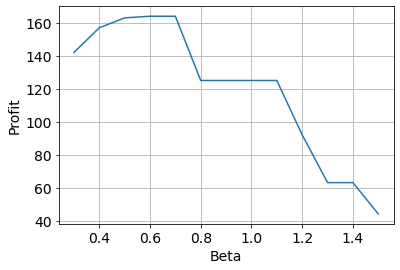

In [28]:
gb_model_tuned_beta = get_best_beta(y_test, preds_gb_tuned)

Посмотрим метрики, порог и матрицу ошибок при такой beta:

In [29]:
gb_threshold_tuned = get_metrics(y_test, preds_gb_tuned, beta=gb_model_tuned_beta)

Best Threshold=0.4643325953522141, F-Score=0.657, Precision=0.736, Recall=0.505


In [30]:
gb_profit_tuned = calc_profit(y_test, preds_gb_tuned, gb_threshold_tuned, 
                              expenses_to_keep, profit_from_kept)
gb_profit_tuned

[[1899   92]
 [ 253  256]]


164

Метрика F-score оказалась выше, чем при стандартном значении beta.  
Также видим, что для максимизации прибыли важнее оказалась метрика  
Precision, нежели Recall: она существенно возросла при значительном  
падении Recall.

Теперь попробуем объединить написанные ранее функции для создания  
метрики, по которой будет происходить поиск параметров:

In [31]:
def profit_score_(y_test, preds, expenses_to_keep=1, profit_from_kept=2):
    
    best_beta = get_best_beta(y_test, preds, verbose=False)
    
    best_threshold = get_metrics(y_test, preds, beta=best_beta, verbose=False)

    profit = calc_profit(y_test, preds, best_threshold,
                         expenses_to_keep, profit_from_kept,
                         verbose=False)
    return profit

In [32]:
profit_score = make_scorer(profit_score_, 
                           expenses_to_keep=expenses_to_keep,
                           profit_from_kept=profit_from_kept,
                           needs_proba=True)

In [33]:
gb_model_tuned_2 = GridSearchCV(gb_model, param_grid=params, scoring=profit_score, cv=5, n_jobs=-1)

gb_model_tuned_2.fit(X_train, y_train);

In [34]:
gb_model_tuned_2.best_params_

{'classifier__learning_rate': 0.03,
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 200}

In [35]:
preds_gb_tuned_2 = gb_model_tuned_2.predict_proba(X_test)[:, 1]

Best Beta = 0.6, Best Profit = 162


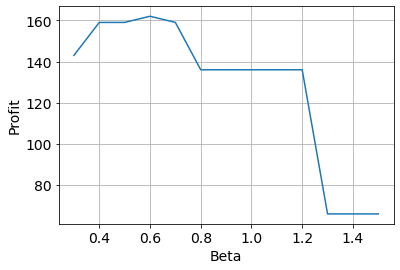

In [36]:
gb_model_tuned_beta_2 = get_best_beta(y_test, preds_gb_tuned_2)

In [37]:
gb_threshold_tuned_2 = get_metrics(y_test, preds_gb_tuned_2, beta=gb_model_tuned_beta_2)

Best Threshold=0.44637821321813226, F-Score=0.655, Precision=0.721, Recall=0.523


In [38]:
gb_profit_tuned_2 = calc_profit(y_test, preds_gb_tuned_2, gb_threshold_tuned_2, 
                                expenses_to_keep, profit_from_kept)
gb_profit_tuned_2

[[1888  103]
 [ 244  265]]


162

Несмотря на то, что теперь поиск параметров производился с учётом  
максимизации прибыли, результат получился чуть хуже. Скорее всего,  
это связано с качеством предсказания модели на тестовой выборке,  
а также с тем, что после настройки параметра beta предыдущая модель  
уже получилась достаточно хорошей.